In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,MaxPool2D
from keras.layers import GlobalAveragePooling2D,Dropout
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

In [5]:
import pickle
import random

In [6]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [8]:
e=150
neurons=2048

In [9]:
class ImagesToDataset(object):

    def __init__(self,PATH='', IMAGE_SIZE = 300):
        self.PATH = PATH
        self.IMAGE_SIZE = IMAGE_SIZE

        self.image_data = []
        self.x_data = []
        self.y_data = []
        self.CATEGORIES = []

        # This will get List of categories
        self.list_categories = []

    def get_categories(self):
        for path in os.listdir(self.PATH):
            if '.DS_Store' in path:
                pass
            else:
                self.list_categories.append(path)
        print("Found Categories ",self.list_categories,'\n')
        return self.list_categories

    def Process_Image(self):
        try:
            """
            Return Numpy array of image
            :return: X_Data, Y_Data
            """
            self.CATEGORIES = self.get_categories()
            for categories in self.CATEGORIES:                                                  # Iterate over categories

                train_folder_path = os.path.join(self.PATH, categories)                         # Folder Path
                class_index = self.CATEGORIES.index(categories)                                 # this will get index for classification

                try:
                  for img in os.listdir(train_folder_path):                                       # This will iterate in the Folder
                    new_path = os.path.join(train_folder_path, img)                             # image Path

                    try:        # if any image is corrupted
                        image_data_temp = cv2.imread(new_path)
                        image_data_temp=cv2.GaussianBlur(image_data_temp,(5,5), 0)
                        hsv = cv2.cvtColor(image_data_temp, cv2.COLOR_BGR2HSV)
                        saturated_hsv = hsv.copy()
                        saturated_hsv[:, :, 1] = cv2.add(hsv[:, :, 1].astype(np.float64), np.array([40], dtype=np.float64))
                        img_data_temp = cv2.cvtColor(saturated_hsv, cv2.COLOR_HSV2BGR)
                        image_data_temp=cv2.cvtColor(image_data_temp,cv2.COLOR_BGR2RGB)                 # Read Image as numbers
                        image_temp_resize = cv2.resize(image_data_temp,(self.IMAGE_SIZE,self.IMAGE_SIZE),interpolation=cv2.INTER_CUBIC)
                        
                        # image_hist=cv2.calcHist([image_temp_resize],[0,1,2],None,[32,32,32],[0,256,0,256,0,256])
                        # cv2.normalize(image_hist,image_hist)
                       # hist_flatten=image_hist.flatten()
                        #image_flatten=image_temp_resize.flatten()
                        #print(image_temp_resize)
                        self.image_data.append([image_temp_resize,class_index])
                        random.shuffle(self.image_data)
                    except:
                        print("error in resizing " + new_path)
                except:
                    print("error in loop")

            data = np.asanyarray(self.image_data,dtype=object)

            # Iterate over the Data
            for x in data:
                self.x_data.append(x[0])        # Get the X_Data
                self.y_data.append(x[1]) 
                # self.features.append(x[2])       # get the label

            X_Data = np.asarray(self.x_data,dtype='float32') / (255.0)      # Normalize Data
            Y_Data = np.asarray(self.y_data)
            # Features=np.asarray(self.features)

            # reshape x_Data

            X_Data = X_Data.reshape(-1, self.IMAGE_SIZE, self.IMAGE_SIZE, 3)

            return X_Data, Y_Data #, Features
        except:
            print("Failed to run Function Process Image ")
            return 0,0
            

    def pickle_image(self,name="train"):

        """
        :return: None Creates a Pickle Object of DataSet
        """
        # Call the Function and Get the Data
        X_Data,Y_Data = self.Process_Image()

        # Write the Entire Data into a Pickle File
        pickle_out = open('/content/drive/MyDrive/X_Data_mp'+name,'wb')
        pickle.dump(X_Data, pickle_out)
        pickle_out.close()

        # Write the Y Label Data
        pickle_out = open('/content/drive/MyDrive/Y_Data_mp'+name, 'wb')
        pickle.dump(Y_Data, pickle_out)
        pickle_out.close()

        # pickle_out = open('Features'+name, 'wb')
        # pickle.dump(Features, pickle_out)
        # pickle_out.close()

        print("Pickled Image Successfully ")
        return X_Data,Y_Data #,Features

    def load_dataset(self,name="train"):

        try:
            # Read the Data from Pickle Object
            X_Temp = open('/content/drive/MyDrive/X_Data_mp'+name,'rb')
            X_Data = pickle.load(X_Temp)

            Y_Temp = open('/content/drive/MyDrive/Y_Data_mp'+name,'rb')
            Y_Data = pickle.load(Y_Temp)

            # Features_Temp = open('Features'+name,'rb')
            # Features = pickle.load(Features_Temp)

            print('Reading Dataset from PIckle Object')

            return X_Data,Y_Data #,Features

        except:
            print('Could not Found Pickle File ')
            print('Loading File and Dataset  ..........')

            X_Data,Y_Data= self.pickle_image(name)
            return X_Data,Y_Data


In [10]:
data_set=ImagesToDataset(PATH="/content/drive/MyDrive/MonkeypoxDS")


In [11]:
x_data,y_data=data_set.load_dataset("DS2")

Reading Dataset from PIckle Object


In [12]:
# X_Temp = open('/content/drive/MyDrive/X_Data_mpMonkeyPoxDataset','rb')
# Y_Temp = open('/content/drive/MyDrive/Y_Data_mpMonkeyPoxDataset','rb')

In [13]:
# x_data=pickle.load(X_Temp)
# y_data=pickle.load(Y_Temp)

In [12]:
len(y_data)

4270

In [13]:
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.3, random_state=40)

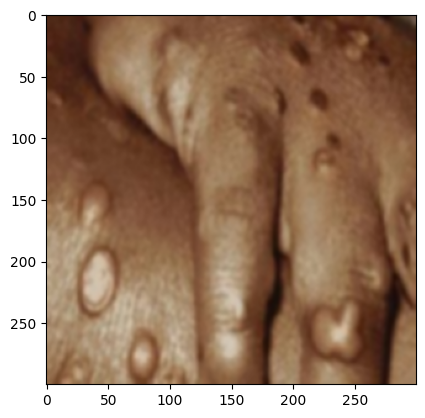

In [14]:
plt.imshow(x_train[100])

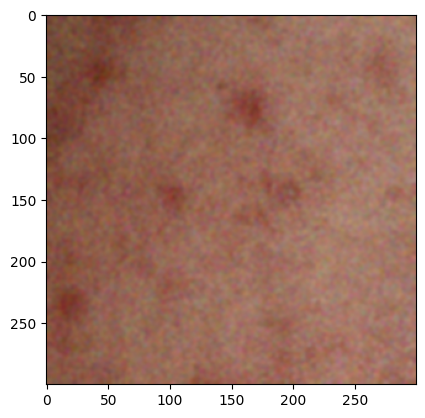

In [15]:
plt.imshow(x_test[10])

In [16]:
len(x_train)

2989

In [17]:
len(y_train)

2989

In [18]:
y_train_cat=to_categorical(y_train)
y_test_cat=to_categorical(y_test)

In [19]:
y_train_cat[70:91]

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [42]:
from keras.applications.vgg16 import VGG16

In [31]:
conv_base=VGG16(weights='imagenet',include_top=False,input_shape=(300,300,3))
model=Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(neurons,activation='relu'))
# model.add(Dense(512,activation='tanh'))
model.add(Dense(4,activation='softmax'))
conv_base.trainable=False

58889256/58889256 [==============================] - 3s 0us/step


In [32]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [33]:
history=model.fit(x_train,y_train_cat,epochs=e,validation_split=0.2)

Epoch 1/150
75/75 [==============================] - 26s 167ms/step - loss: 5.0366 - accuracy: 0.5353 - val_loss: 1.2410 - val_accuracy: 0.5686
Epoch 2/150
75/75 [==============================] - 8s 107ms/step - loss: 0.4272 - accuracy: 0.8335 - val_loss: 0.8405 - val_accuracy: 0.6940
Epoch 3/150
75/75 [==============================] - 8s 107ms/step - loss: 0.2343 - accuracy: 0.9218 - val_loss: 0.4784 - val_accuracy: 0.8344
Epoch 4/150
75/75 [==============================] - 8s 107ms/step - loss: 0.1586 - accuracy: 0.9536 - val_loss: 0.3568 - val_accuracy: 0.8880
Epoch 5/150
75/75 [==============================] - 8s 107ms/step - loss: 0.1287 - accuracy: 0.9586 - val_loss: 0.5981 - val_accuracy: 0.8144
Epoch 6/150
75/75 [==============================] - 8s 107ms/step - loss: 0.1307 - accuracy: 0.9565 - val_loss: 0.3886 - val_accuracy: 0.8746
Epoch 7/150
75/75 [==============================] - 8s 107ms/step - loss: 0.0947 - accuracy: 0.9762 - val_loss: 0.5438 - val_accuracy: 0.817

In [34]:
y_pred=model.predict(x_test)

41/41 [==============================] - 4s 84ms/step


In [35]:
y_pred2=np.argmax(y_pred, axis=1)
y_test2=np.argmax(y_test_cat, axis=1)
cm=confusion_matrix(y_test2,y_pred2)

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       317
           1       0.90      0.83      0.87       315
           2       0.95      0.93      0.94       339
           3       0.87      0.93      0.90       310

    accuracy                           0.90      1281
   macro avg       0.90      0.90      0.90      1281
weighted avg       0.90      0.90      0.90      1281



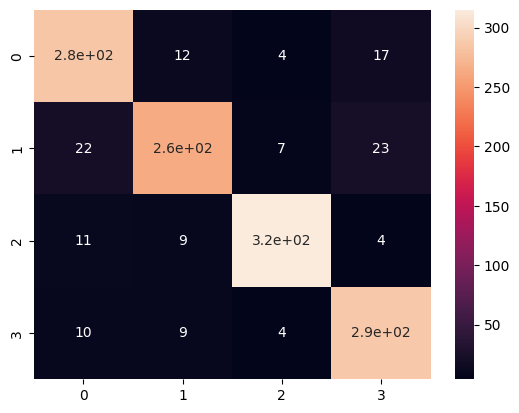

In [36]:
sns.heatmap(cm,annot=True)
print(classification_report(y_test2,y_pred2))

Sigmoid with VGG16

In [37]:

conv_base2=VGG16(weights='imagenet',include_top=False,input_shape=(300,300,3))
model2=Sequential()
model2.add(conv_base2)
model2.add(Flatten())
model2.add(Dense(neurons,activation='sigmoid'))
#model2.add(Dense(4096,activation='relu'))
model2.add(Dense(4,activation='softmax'))
conv_base2.trainable=False

In [38]:
model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [39]:
history2=model2.fit(x_train,y_train_cat,epochs=e,validation_split=0.2)

Epoch 1/150
75/75 [==============================] - 11s 127ms/step - loss: 3.0361 - accuracy: 0.3693 - val_loss: 1.1952 - val_accuracy: 0.4649
Epoch 2/150
75/75 [==============================] - 9s 121ms/step - loss: 1.0475 - accuracy: 0.5592 - val_loss: 1.0670 - val_accuracy: 0.5485
Epoch 3/150
75/75 [==============================] - 9s 121ms/step - loss: 0.8237 - accuracy: 0.6780 - val_loss: 0.8788 - val_accuracy: 0.6438
Epoch 4/150
75/75 [==============================] - 9s 121ms/step - loss: 0.6482 - accuracy: 0.7796 - val_loss: 0.7854 - val_accuracy: 0.6957
Epoch 5/150
75/75 [==============================] - 9s 121ms/step - loss: 0.5197 - accuracy: 0.8402 - val_loss: 0.5446 - val_accuracy: 0.8395
Epoch 6/150
75/75 [==============================] - 9s 121ms/step - loss: 0.3763 - accuracy: 0.9017 - val_loss: 0.4732 - val_accuracy: 0.8696
Epoch 7/150
75/75 [==============================] - 9s 121ms/step - loss: 0.2762 - accuracy: 0.9281 - val_loss: 0.4433 - val_accuracy: 0.857

In [40]:
y_pred2=model2.predict(x_test)

41/41 [==============================] - 4s 90ms/step


In [41]:
y_pred22=np.argmax(y_pred2, axis=1)
y_test22=np.argmax(y_test_cat, axis=1)
cm=confusion_matrix(y_test22,y_pred22)

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       317
           1       0.88      0.87      0.88       315
           2       0.96      0.93      0.94       339
           3       0.85      0.93      0.89       310

    accuracy                           0.90      1281
   macro avg       0.90      0.90      0.90      1281
weighted avg       0.91      0.90      0.90      1281



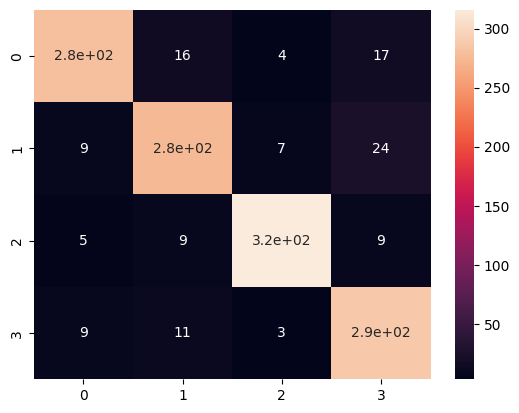

In [42]:
sns.heatmap(cm,annot=True)
print(classification_report(y_test22,y_pred22))

tanh with vgg16

In [43]:
conv_base3=VGG16(weights='imagenet',include_top=False,input_shape=(300,300,3))
model3=Sequential()
model3.add(conv_base3)
model3.add(Flatten())
model3.add(Dense(neurons,activation='tanh'))
#model3.add(Dense(4098,activation='relu'))
model3.add(Dense(4,activation='softmax'))
conv_base3.trainable=False

58889256/58889256 [==============================] - 4s 0us/step


In [44]:
model3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [45]:
history3=model3.fit(x_train,y_train_cat,epochs=e,validation_split=0.2)

Epoch 1/150
75/75 [==============================] - 6s 61ms/step - loss: 3.8574 - accuracy: 0.3873 - val_loss: 1.2861 - val_accuracy: 0.3963
Epoch 2/150
75/75 [==============================] - 4s 52ms/step - loss: 1.1515 - accuracy: 0.4659 - val_loss: 1.1492 - val_accuracy: 0.4766
Epoch 3/150
75/75 [==============================] - 4s 53ms/step - loss: 1.1018 - accuracy: 0.5115 - val_loss: 1.1408 - val_accuracy: 0.5117
Epoch 4/150
75/75 [==============================] - 4s 52ms/step - loss: 1.0049 - accuracy: 0.5554 - val_loss: 1.2775 - val_accuracy: 0.4181
Epoch 5/150
75/75 [==============================] - 4s 52ms/step - loss: 0.9110 - accuracy: 0.6177 - val_loss: 0.9780 - val_accuracy: 0.5702
Epoch 6/150
75/75 [==============================] - 4s 53ms/step - loss: 0.8616 - accuracy: 0.6554 - val_loss: 0.8847 - val_accuracy: 0.6522
Epoch 7/150
75/75 [==============================] - 4s 52ms/step - loss: 0.7327 - accuracy: 0.7315 - val_loss: 0.7827 - val_accuracy: 0.6973
Epoch 

In [46]:
y_pred3=model3.predict(x_test)

41/41 [==============================] - 2s 42ms/step


In [47]:
y_pred23=np.argmax(y_pred3, axis=1)
y_test23=np.argmax(y_test_cat, axis=1)
cm=confusion_matrix(y_test23,y_pred23)

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       317
           1       0.81      0.78      0.80       315
           2       0.80      0.90      0.85       339
           3       0.86      0.85      0.86       310

    accuracy                           0.83      1281
   macro avg       0.83      0.83      0.83      1281
weighted avg       0.83      0.83      0.83      1281



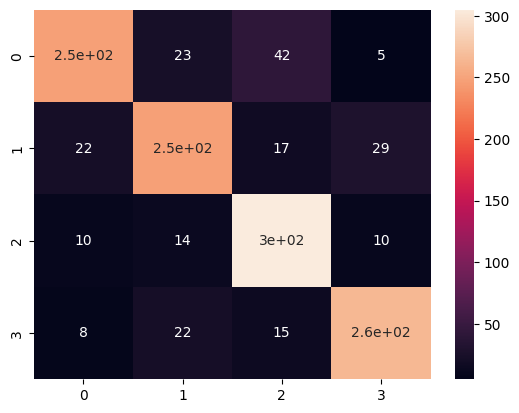

In [48]:
sns.heatmap(cm,annot=True)
print(classification_report(y_test23,y_pred23))

linear with vgg16

In [27]:
conv_base33=VGG16(weights='imagenet',include_top=False,input_shape=(300,300,3))
model33=Sequential()
model33.add(conv_base33)
model33.add(Flatten())
model33.add(Dense(neurons,activation='linear'))
#model33.add(Dense(4098,activation='relu'))
model33.add(Dense(4,activation='softmax'))
conv_base33.trainable=False

In [28]:
model33.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [29]:
history33=model33.fit(x_train,y_train_cat,epochs=e,validation_split=0.2)

Epoch 1/150
75/75 [==============================] - 6s 65ms/step - loss: 26.1307 - accuracy: 0.5475 - val_loss: 4.6106 - val_accuracy: 0.6371
Epoch 2/150
75/75 [==============================] - 4s 52ms/step - loss: 2.1467 - accuracy: 0.7938 - val_loss: 3.9225 - val_accuracy: 0.6756
Epoch 3/150
75/75 [==============================] - 4s 53ms/step - loss: 0.7445 - accuracy: 0.8846 - val_loss: 1.0992 - val_accuracy: 0.8562
Epoch 4/150
75/75 [==============================] - 4s 52ms/step - loss: 0.2629 - accuracy: 0.9377 - val_loss: 1.4334 - val_accuracy: 0.8361
Epoch 5/150
75/75 [==============================] - 4s 52ms/step - loss: 0.1556 - accuracy: 0.9536 - val_loss: 1.3188 - val_accuracy: 0.8579
Epoch 6/150
75/75 [==============================] - 4s 52ms/step - loss: 0.6731 - accuracy: 0.9176 - val_loss: 4.6104 - val_accuracy: 0.6990
Epoch 7/150
75/75 [==============================] - 4s 52ms/step - loss: 0.7369 - accuracy: 0.9193 - val_loss: 1.1077 - val_accuracy: 0.8679
Epoch

41/41 [==============================] - 2s 37ms/step
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       317
           1       0.87      0.84      0.86       315
           2       0.95      0.92      0.93       339
           3       0.86      0.92      0.89       310

    accuracy                           0.89      1281
   macro avg       0.89      0.89      0.89      1281
weighted avg       0.89      0.89      0.89      1281



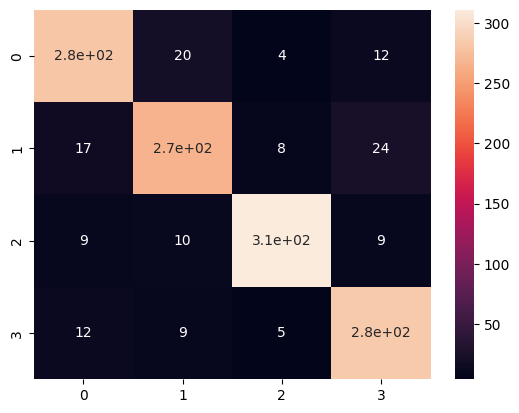

In [30]:
y_pred33=model33.predict(x_test)
y_pred233=np.argmax(y_pred33, axis=1)
y_test233=np.argmax(y_test_cat, axis=1)
cm=confusion_matrix(y_test233,y_pred233)
sns.heatmap(cm,annot=True)
print(classification_report(y_test233,y_pred233))

inceptionV3

In [24]:
from keras.applications import InceptionV3

relu with iv3

In [25]:
conv_base7=InceptionV3(weights='imagenet',include_top=False,input_shape=(300,300,3))
model7=Sequential()
model7.add(conv_base7)
model7.add(GlobalAveragePooling2D())
model7.add(Dense(neurons,activation='relu'))
#model7.add(Dense(4096,activation='relu'))
model7.add(Dense(4,activation='softmax'))
conv_base7.trainable=False

87910968/87910968 [==============================] - 5s 0us/step


In [26]:
model7.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [27]:
history7=model7.fit(x_train,y_train_cat,epochs=e,validation_split=0.2)

Epoch 1/150
75/75 [==============================] - 12s 83ms/step - loss: 0.8810 - accuracy: 0.7348 - val_loss: 0.4201 - val_accuracy: 0.8545
Epoch 2/150
75/75 [==============================] - 3s 35ms/step - loss: 0.3101 - accuracy: 0.8892 - val_loss: 0.3289 - val_accuracy: 0.8829
Epoch 3/150
75/75 [==============================] - 3s 35ms/step - loss: 0.1714 - accuracy: 0.9494 - val_loss: 0.2596 - val_accuracy: 0.9064
Epoch 4/150
75/75 [==============================] - 3s 35ms/step - loss: 0.1178 - accuracy: 0.9603 - val_loss: 0.2655 - val_accuracy: 0.9064
Epoch 5/150
75/75 [==============================] - 3s 34ms/step - loss: 0.1190 - accuracy: 0.9590 - val_loss: 0.2081 - val_accuracy: 0.9298
Epoch 6/150
75/75 [==============================] - 3s 34ms/step - loss: 0.0721 - accuracy: 0.9778 - val_loss: 0.2292 - val_accuracy: 0.9247
Epoch 7/150
75/75 [==============================] - 3s 35ms/step - loss: 0.0302 - accuracy: 0.9950 - val_loss: 0.1825 - val_accuracy: 0.9448
Epoch

41/41 [==============================] - 3s 34ms/step
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       317
           1       0.94      0.97      0.95       315
           2       0.97      0.97      0.97       339
           3       0.93      0.98      0.96       310

    accuracy                           0.96      1281
   macro avg       0.96      0.96      0.96      1281
weighted avg       0.96      0.96      0.96      1281



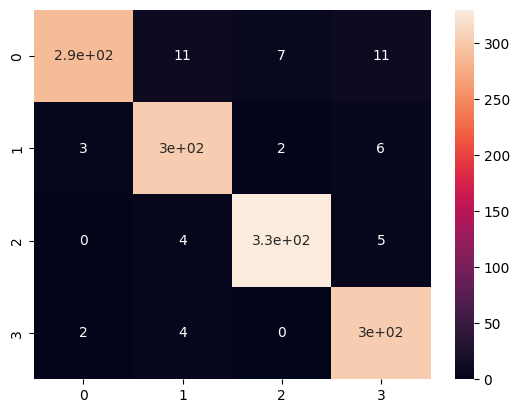

In [28]:
y_pred7=model7.predict(x_test)
y_pred27=np.argmax(y_pred7, axis=1)
y_test27=np.argmax(y_test_cat, axis=1)
cm=confusion_matrix(y_test27,y_pred27)
sns.heatmap(cm,annot=True)
print(classification_report(y_test27,y_pred27))

Sigmoid with iv3

In [29]:
conv_base8=InceptionV3(weights='imagenet',include_top=False,input_shape=(300,300,3))
model8=Sequential()
model8.add(conv_base8)
model8.add(GlobalAveragePooling2D())
model8.add(Dense(neurons,activation='sigmoid'))
#model8.add(Dense(4096,activation='relu'))
model8.add(Dense(4,activation='softmax'))
conv_base8.trainable=False

In [30]:
model8.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [31]:
history8=model8.fit(x_train,y_train_cat,epochs=e,validation_split=0.2)

Epoch 1/150
75/75 [==============================] - 9s 59ms/step - loss: 0.9484 - accuracy: 0.7018 - val_loss: 0.4217 - val_accuracy: 0.8579
Epoch 2/150
75/75 [==============================] - 3s 35ms/step - loss: 0.3399 - accuracy: 0.8879 - val_loss: 0.3866 - val_accuracy: 0.8629
Epoch 3/150
75/75 [==============================] - 3s 35ms/step - loss: 0.2528 - accuracy: 0.9097 - val_loss: 0.4855 - val_accuracy: 0.8344
Epoch 4/150
75/75 [==============================] - 3s 35ms/step - loss: 0.2089 - accuracy: 0.9281 - val_loss: 0.2398 - val_accuracy: 0.9197
Epoch 5/150
75/75 [==============================] - 3s 35ms/step - loss: 0.1121 - accuracy: 0.9653 - val_loss: 0.2167 - val_accuracy: 0.9298
Epoch 6/150
75/75 [==============================] - 3s 34ms/step - loss: 0.1150 - accuracy: 0.9615 - val_loss: 0.1943 - val_accuracy: 0.9331
Epoch 7/150
75/75 [==============================] - 3s 34ms/step - loss: 0.0564 - accuracy: 0.9879 - val_loss: 0.1996 - val_accuracy: 0.9365
Epoch 

41/41 [==============================] - 2s 25ms/step
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       317
           1       0.94      0.95      0.94       315
           2       0.96      0.97      0.96       339
           3       0.92      0.98      0.95       310

    accuracy                           0.95      1281
   macro avg       0.95      0.95      0.95      1281
weighted avg       0.95      0.95      0.95      1281



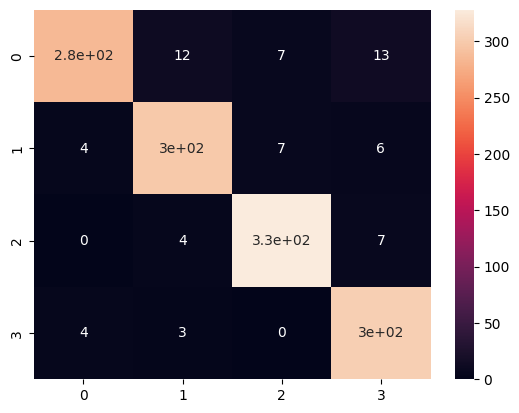

In [32]:
y_pred8=model8.predict(x_test)
y_pred28=np.argmax(y_pred8, axis=1)
y_test28=np.argmax(y_test_cat, axis=1)
cm=confusion_matrix(y_test28,y_pred28)
sns.heatmap(cm,annot=True)
print(classification_report(y_test28,y_pred28))

tanh with iv3

In [33]:
conv_base9=InceptionV3(weights='imagenet',include_top=False,input_shape=(300,300,3))
model9=Sequential()
model9.add(conv_base9)
model9.add(GlobalAveragePooling2D())
model9.add(Dense(neurons,activation='tanh'))
#model9.add(Dense(4096,activation='relu'))
model9.add(Dense(4,activation='softmax'))
conv_base9.trainable=False

In [34]:
model9.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [35]:
history9=model9.fit(x_train,y_train_cat,epochs=e,validation_split=0.2)

Epoch 1/150
75/75 [==============================] - 9s 59ms/step - loss: 1.9842 - accuracy: 0.6658 - val_loss: 0.4810 - val_accuracy: 0.8227
Epoch 2/150
75/75 [==============================] - 3s 34ms/step - loss: 0.3769 - accuracy: 0.8565 - val_loss: 0.3633 - val_accuracy: 0.8562
Epoch 3/150
75/75 [==============================] - 3s 35ms/step - loss: 0.2259 - accuracy: 0.9197 - val_loss: 0.2763 - val_accuracy: 0.8963
Epoch 4/150
75/75 [==============================] - 3s 35ms/step - loss: 0.1506 - accuracy: 0.9460 - val_loss: 0.2153 - val_accuracy: 0.9281
Epoch 5/150
75/75 [==============================] - 3s 35ms/step - loss: 0.1138 - accuracy: 0.9594 - val_loss: 0.3366 - val_accuracy: 0.8880
Epoch 6/150
75/75 [==============================] - 3s 34ms/step - loss: 0.0706 - accuracy: 0.9762 - val_loss: 0.1800 - val_accuracy: 0.9448
Epoch 7/150
75/75 [==============================] - 3s 34ms/step - loss: 0.0576 - accuracy: 0.9812 - val_loss: 0.1762 - val_accuracy: 0.9482
Epoch 

41/41 [==============================] - 2s 24ms/step
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       317
           1       0.94      0.97      0.95       315
           2       0.96      0.97      0.97       339
           3       0.93      0.97      0.95       310

    accuracy                           0.95      1281
   macro avg       0.95      0.95      0.95      1281
weighted avg       0.95      0.95      0.95      1281



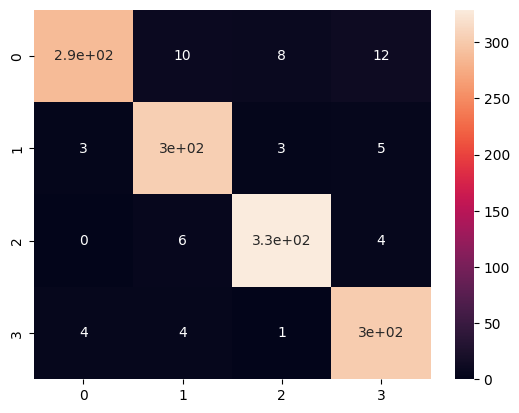

In [36]:
y_pred9=model9.predict(x_test)
y_pred29=np.argmax(y_pred9, axis=1)
y_test29=np.argmax(y_test_cat, axis=1)
cm=confusion_matrix(y_test29,y_pred29)
sns.heatmap(cm,annot=True) 
print(classification_report(y_test29,y_pred29))

linear with iv3

In [37]:
conv_base93=InceptionV3(weights='imagenet',include_top=False,input_shape=(300,300,3))
model93=Sequential()
model93.add(conv_base93)
model93.add(GlobalAveragePooling2D())
model93.add(Dense(neurons,activation='linear'))
#model93.add(Dense(4096,activation='relu'))
model93.add(Dense(4,activation='softmax'))
conv_base93.trainable=False

In [38]:
model93.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [39]:
history93=model93.fit(x_train,y_train_cat,epochs=e,validation_split=0.2)

Epoch 1/150
75/75 [==============================] - 9s 58ms/step - loss: 1.8741 - accuracy: 0.7194 - val_loss: 0.4116 - val_accuracy: 0.8478
Epoch 2/150
75/75 [==============================] - 3s 35ms/step - loss: 0.3140 - accuracy: 0.8925 - val_loss: 0.3585 - val_accuracy: 0.8679
Epoch 3/150
75/75 [==============================] - 3s 35ms/step - loss: 0.1976 - accuracy: 0.9335 - val_loss: 0.4244 - val_accuracy: 0.8729
Epoch 4/150
75/75 [==============================] - 3s 35ms/step - loss: 0.2215 - accuracy: 0.9134 - val_loss: 0.2377 - val_accuracy: 0.9197
Epoch 5/150
75/75 [==============================] - 3s 34ms/step - loss: 0.1126 - accuracy: 0.9590 - val_loss: 0.2508 - val_accuracy: 0.9281
Epoch 6/150
75/75 [==============================] - 3s 35ms/step - loss: 0.0866 - accuracy: 0.9724 - val_loss: 0.3457 - val_accuracy: 0.8997
Epoch 7/150
75/75 [==============================] - 3s 34ms/step - loss: 0.0853 - accuracy: 0.9699 - val_loss: 0.2408 - val_accuracy: 0.9348
Epoch 

41/41 [==============================] - 2s 24ms/step
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       317
           1       0.94      0.95      0.94       315
           2       0.96      0.97      0.97       339
           3       0.92      0.97      0.95       310

    accuracy                           0.95      1281
   macro avg       0.95      0.95      0.95      1281
weighted avg       0.95      0.95      0.95      1281



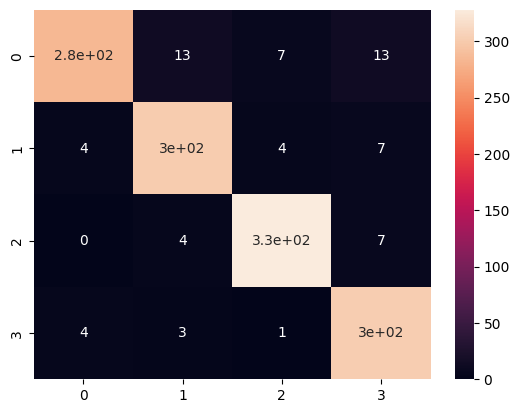

In [40]:
y_pred93=model93.predict(x_test)
y_pred293=np.argmax(y_pred93, axis=1)
y_test293=np.argmax(y_test_cat, axis=1)
cm=confusion_matrix(y_test293,y_pred293)
sns.heatmap(cm,annot=True) 
print(classification_report(y_test293,y_pred293))